In [5]:
# Setup

!pip install --upgrade torch
!pip install --upgrade pyro-ppl
!pip install --upgrade scipy
!pip install --upgrade matplotlib
!pip install --upgrade scikit-optimize

Requirement already up-to-date: torch in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (1.4.0)
Requirement already up-to-date: pyro-ppl in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (1.3.0)
Requirement already up-to-date: scipy in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (1.4.1)
Requirement already up-to-date: matplotlib in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (3.2.1)
Requirement already up-to-date: scikit-optimize in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (0.7.4)


In [6]:
import pyro
import torch
import torch.tensor as tensor
import pyro.distributions as dist
# from torch.distributions import Binomial, Gamma, Uniform
from pyro.distributions import Binomial, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma

import numpy as np

import scipy
from skopt import gp_minimize 
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot

from collections import namedtuple
import time
seed = 0

In [7]:
# Measuring overhead
import time

# .1s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

if len(l) > 5:
    print("Done")
print(f"Scalar version took: {time.time() - start}")

# 30x slower, 3.2s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(tensor(i))

if len(l) > 5:
    print("Done")
print(f"Tensor version took: {time.time() - start}")

# do it in one pass
# this wraps the array in tensor, aka tensor([]),
# but accessing a single element gives back a tensor
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

# .13s 
l = torch.tensor(l)
if len(l) > 5:
    print("Done")
print(f"Tensor convert array version took: {time.time() - start}")

Done
Scalar version took: 0.1151268482208252
Done
Tensor version took: 3.2699129581451416
Done
Tensor convert array version took: 0.12297391891479492


In [8]:
# Likelihood functions
# These assume univariate currently

# TODO:
# 1) Explore constraining alphas using prevalence estimate, namely E(P(D)) = alpha0 / (alpha0 + alpha1 + alpha2 + alphaBoth) (as long as all case counts are mutually exclusive)
# 2) Can DM approximate NB + Multinomial? If so do we need mixture at all? But if we don't have that how do we model % disease-afffecting genes in each hypothesis(maybe proportion of alphas?)
# rr: relative risk
def pVgivenD(rr, pV):
    return (rr * pV) / (rr * pV + (1 - pV))

# pD: prevalence, tensor of mConditions x 1
# pVgivenD: tensor of mConditions x 1
# pV: allele frequency
def pVgivenNotD(pD, pV, pVgivenD):
    p = (pV - (pD*pVgivenD).sum()) / (1 - pD.sum())
    assert(p >= 0)
    return p

# def pVgivenNotD(pD, pV, pVgivenD):
#     p = (pV - (pD*pVgivenD)) / (1 - pD)
#     assert(p >= 0)
#     return p

def pDgivenV(pD, pVgivenD, pV):
    return pVgivenD * pD / pV

# works like shit
def llUnivariateSingleGeneJensen(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return pi0 * Binomial(total_count=n, probs=pD).log_prob(xCase) + pi1*Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)

def llUnivariateSingleGene(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return torch.log(pi0 * torch.exp(Binomial(total_count=n, probs=pD).log_prob(xCase)) + pi1*torch.exp(Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)))

# alphas shape: [2] #corresponding to cases and controls
def llUnivariateSingleGeneBetaBinomial(xCtrl, xCase, pD, alphas, pi0, pi1):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    # what is the 
    h0 = pi0 * torch.exp( Binomial(total_count=n, probs=pD).log_prob(xCase) )
    h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alphas[1], concentration0=alphas[0]).log_prob(xCase) )
    return torch.log( h0 + h1 )

# TODO: support pooled and non-pooled controls
# TODO: think about whether we need overlapping cases (both disease1 + disease2) or whether that can be inferred
# altCounts.shape = [1 control + nConditions cases, 1]
# alphas shape: [nConditions + 2] #1 ctrl + nCondition cases; for now the last condition in nCondition cases is for individuals who has all of the previous nConditions
# in a more multivariate setting we will need more information, aka mapping to which combinations of conditions these people have
# xCases: we have nConditions cases
# pDs shape: [nConditions]
# TODO: make this more effificent by taking alphas tensor of shape (1 + nConditions)
def llPooledBivariateSingleGene(altCounts, pDs, alpha0, alpha1, alpha2, alphaBoth, pi0, pi1, pi2, piBoth):
    # currently assume altCounts are all independent (in simulation), or 0 for everything but first condition
    n = altCounts.sum()
    alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
    print("n is ", n)
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    # what is the 
    case1nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[0]).log_prob(altCounts[1]) )
    case2nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[1]).log_prob(altCounts[2]) )
    h0 = pi0 * case1nullLikelihood * case2nullLikelihood
    h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCounts[1]) ) * case2nullLikelihood
    h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCounts[2]) ) * case1nullLikelihood
    h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCounts))
    print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
    return torch.log( h0 + h1 + h2 + h3 )

# shape of altCountsByGene: [nGenes, nConditions, 2]
# last dimension is 
# 2nd dimension altCountsCasesByGene must match controls, or the control nConditions must be 1 (pooled controls)
def likelihoodUnivariate(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    
    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(params):
        pDgivenV = params[0]
        pi1 = params[1]
        pi0 = 1 - pi1
        
        if(pDgivenV >= 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            print("returning inf")
            return float("-inf")
    
        logLikelihood = 0
        penaltyCount = float(nGenes)
        
        # 
        for geneIdx in range(nGenes):
            ctrlAltCount = altCountsByGene[geneIdx, 0, 0]
            caseAltCount = altCountsByGene[geneIdx, 0, 1]
            pd = pDs[0]
            
            if ctrlAltCount == 0 and caseAltCount == 0:
                print("skipping", geneIdx)
                continue

            # this is insanely slow
            ll = llUnivariateSingleGene(ctrlAltCount, caseAltCount, pd, pi0, pi1, pDgivenV)

            if torch.isnan(ll) or torch.isinf(ll):
                print(f"nan or 0 likelihood: like: {like}, p1: {pi1}, pDgivenV: {pDgivenV}, gene: {geneIdx}, ctrlCount: {ctrlAltCount}, caseCount: {caseAltCount}")
                penaltyCount -= 1
                continue
                
            logLikelihood += ll
        
    
        if penaltyCount == 0:
            penaltyCount = 1
    
        return -logLikelihood * (nGenes / penaltyCount)
    
    return likelihood

def likelihoodUnivariateFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    def likelihood(params):
        pi1, pDgivenV = params

        pi0 = 1.0 - pi1

        if(pDgivenV > 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            return float("inf")
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = Binomial(total_count=geneSums, probs=pDgivenV)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))
        
        return - torch.log(component0 + component1).sum()
    
    return likelihood

def likelihoodUnivariateBetaBinomialFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    def likelihood(params):
        pi1, alpha1, alpha0 = params

        if alpha1 < 0 or alpha0 < 0 or pi1 < 0 or pi1 > 1:
            return float("inf")
        
        pi0 = 1.0 - pi1

        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alpha0)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))

        return - torch.log(component0 + component1).sum()
    
    return likelihood

def getUnivariateAlpha0(alpha1, pD):
    return ((1-pD) / pD)*alpha1

# doesn't really work constraint looks wrong
def likelihoodUnivariateBetaBinomialConstrainedFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    pNotDRatio = (1 - pD)/pD
    def likelihood(params):
        pi1, alpha1 = params
        
        if alpha1 < 0 or pi1 < 0 or pi1 > 1:
            return float("inf")
        
        pi0 = 1.0 - pi1
        
        alpha0 = pNotDRatio*alpha1
        
        assert(alpha0 > 0)
        
        print("alpha0",alpha0)
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alpha0)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))

        return - torch.log(component0 + component1).sum()
    
    return likelihood

# Bivariate likelihood function modeled on:
#def llPooledBivariateSingleGene(altCounts, pDs, alpha0, alpha1, alpha2, alphaBoth, pi0, pi1, pi2, piBoth):
# # currently assume altCounts are all independent (in simulation), or 0 for everything but first condition
# n = altCounts.sum()
# alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
# case1nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[0]).log_prob(altCounts[1]) )
# case2nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[1]).log_prob(altCounts[2]) )
# h0 = pi0 * case1nullLikelihood * case2nullLikelihood
# h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCounts[1]) ) * case2nullLikelihood
# h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCounts[2]) ) * case1nullLikelihood
# h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCounts))
# print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
# return torch.log( h0 + h1 + h2 + h3 )
def likelihoodBivariateFast(altCountsByGene, pDs):
    nGenes = altCountsByGene.shape[0]

    geneSums = altCountsByGene[:, :, :].sum([1,2])

    ctrlCounts = altCountsByGene[:, 0, 0]
    altCountsCases = altCountsByGene[:, :, 1]
    
    altCountsFlat = []
    for geneIdx in range(nGenes):
        altCountsFlat.append([ctrlCounts[geneIdx], *altCountsByGene[geneIdx, :, 1].flatten()])

    altCountsFlat = tensor(altCountsFlat)
    print(altCountsFlat)
    nullLikelihoods = torch.exp(Binomial(total_count=geneSums.expand([3, 20_000]).T, probs=pDs).log_prob(altCountsCases))

    allNull = nullLikelihoods.prod(1)
    case1null = nullLikelihoods[:, 0]
    case2null = nullLikelihoods[:, 1]
    caseBothNull = nullLikelihoods[:, 2]

    case1and2Null = case1null * case2null
    
    case1andBothNull = nullLikelihoods[:, 0] * caseBothNull
    case2andBothNull = nullLikelihoods[:, 1] * caseBothNull
    def likelihood1(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1]) ) * case2andBothNull
        h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2]) ) * case1andBothNull
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood1a(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1]) ) * case2Null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2]) ) * case1Null
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood1b(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1]) )
        h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2]) )
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood2(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1] + altCountsFlat[:, 3]) ) * case2andBothNull
        h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2] + altCountsFlat[:, 3]) ) * case1andBothNull
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood2a(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1] + altCountsFlat[:, 3]) ) * case2null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2] + altCountsFlat[:, 3]) ) * case1null
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()

    def likelihood2b(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1] + altCountsFlat[:, 3]) )
        h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2] + altCountsFlat[:, 3]) )
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood3(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1] + altCountsFlat[:, 2] + altCountsFlat[:, 3]) )
        h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2] + altCountsFlat[:, 1] + altCountsFlat[:, 3]) )
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood4(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( DirichletMultinomial(total_count=geneSums - altCountsFlat[:, 3], concentration=tensor([alpha1, alpha2])).log_prob(altCountsFlat[:, 1:3]))
        h2 = pi2 * torch.exp( DirichletMultinomial(total_count=geneSums , concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 ).sum()

    return likelihood1, likelihood1a, likelihood1b, likelihood2, likelihood2a, likelihood2b, likelihood3, likelihood4

def cb(f, context):
    print("got callback", f, context)

# TODO: update for multivariate
def fitFnUniveriate(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
    costFn = likelihoodUnivariateFast(altCountsByGene, pDs)
    
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)

    randomDist = Uniform(1/nGenes, .5)
    randomDist2 = Uniform(0, 1)
    
        # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
#     pDgivenVbounds = ( pVgivenD(2, 1e-6) * .001 / 1e-6, pVgivenD(100, 1e-2) * .1 / 1e-2 )
#     pi1Bounds = ( 1/nGenes,  1 )
#     bounds = [pDgivenVbounds, pi1Bounds]
    for i in range(nEpochs):
        best = float("inf")
        bestParams = []
        for y in range(100):
            # pi1, p(D|V)
            fnArgs = [randomDist.sample(), randomDist2.sample()]
            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
                
        if debug:
            print(f"best ll: {best}, params: {bestParams}")

        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        
        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        pi1, pDgivenV= fit["x"]
        if pDgivenV < 0 or pDgivenV > 1 or pi1 < 1/nGenes or pi1 > 1:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params}


# TODO: maybe beta distribution should be constrained such that variance is that of the data?
# or maybe there's an analog to 0 mean liability variance?
def fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
    costFn = likelihoodUnivariateBetaBinomialFast(altCountsByGene, pDs)
    
    llsAll = []
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)
    remainingEpochs = nEpochs
    
    randomDist = Uniform(1/nGenes, .5)
    randomDist2 = Uniform(100, 25000)
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    while remainingEpochs > 0:
        best = float("inf")
        bestParams = []
        for i in range(50):
            # pi1, alpha1, alpha0
            fnArgs = [randomDist.sample(), randomDist2.sample(), randomDist2.sample()]
            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
        
        if debug:
            print(f"best ll: {best}, bestParams: {bestParams}")

        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        #fit = scipy.optimize.basinhopping(costFn, x0 = bestParams)
        if debug:
            print(f"epoch {remainingEpochs}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        
        pi1, alpha1, alpha0 = fit["x"]
        # TODO: is pi1 > .5 restriction sound?
        if pi1 < 1/nGenes or pi1 > .5 or alpha1 <= 0 or alpha0 <= 0:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
            
        remainingEpochs -= 1
        
        ll = fit["fun"]
        llsAll.append(ll)
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params, "llTrajectory": llsAll}

# Constrain alpha0 by using 1-P(D)
# def fitFnUniveriateBetaBinomialConstrained(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
#     costFn = likelihoodUnivariateBetaBinomialConstrainedFast(altCountsByGene, pDs)
    
#     llsAll = []
#     lls = []
#     params = []

#     minLLDiff = 1
#     thresholdHitCount = 0
    
#     randomDist = Uniform(0, 1)
#     randomDist2 = Uniform(1, 10000)
#     fnArgs = [0, 0]
#     # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
#     # P(V|D) * P(D) / P(V)
#     nGenes = len(altCountsByGene)
#     remainingEpochs = nEpochs
#     while remainingEpochs > 0:
#         # pi1
#         fnArgs[0] = randomDist.sample()
#         # alpha1
#         fnArgs[1] = randomDist2.sample()
#         fit = scipy.optimize.minimize(costFn, x0 = fnArgs, method='Nelder-Mead', options={"maxiter": 10000})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        
#         if debug:
#             print(f"epoch {remainingEpochs}")
#             print(fit)

#         if not fit["success"] is True:
#             if debug:
#                 print("Failed to converge")
#                 print(fit)
#             continue
        
        
#         pi1, alpha1 = fit["x"]
#         # TODO: is pi1 > .5 restriction sound?
#         if pi1 < 1/nGenes or pi1 > .5 or alpha1 <= 0:
#             if debug:
#                 print("Failed to converge")
#                 print(fit)
#             continue
            
#         remainingEpochs -= 1
        
#         ll = fit["fun"]
#         llsAll.append(ll)
#         if len(lls) == 0:
#             lls.append(ll)
#             params.append(fit["x"])
#             continue

#         minPrevious = min(lls)
        
#         if debug:
#             print("minPrevious", minPrevious)
            
#         # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
#         if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
#             if debug:
#                 print(f"better by at >= {minLLDiff}; new ll: {fit}")

#             lls.append(ll)
#             params.append(fit["x"])
            
#             thresholdHitCount = 0
#             continue

#         thresholdHitCount += 1
        
#         if thresholdHitCount == minLLThresholdCount:
#             break
            
#     return {"lls": lls, "params": params, "llTrajectory": llsAll}

# TODO: maybe beta distribution should be constrained such that variance is that of the data?
# or maybe there's an analog to 0 mean liability variance
def fitFnBivariate(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, K = 4, debug = False, costFnIdx = 0):
    costFunctions = likelihoodBivariateFast(altCountsByGene, pDs)

    costFn = costFunctions[costFnIdx]
    print("past", costFn)
    llsAll = []
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)
    
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    pi0Dist = Uniform(.5, 1)
    alphasDist = Uniform(100, 25000)    
    for i in range(nEpochs):
        # TODO: should we constrain alpha0 to the pD, i.e
        # E[P(D)] = alpha1 / sum(alphasRes)
        # P(D) * (alphasRes) = alpha1
        best = float("inf")
        bestParams = []
        for y in range(100):
            pi0 = pi0Dist.sample()
            pis = Uniform(1/nGenes, 1-pi0).sample([K-1])
            pis = pis/(pis.sum() + pi0)
#             print("pi0", pi0, "pis", pis, "sum", pis.sum())
            fnArgs = [*pis, *alphasDist.sample([K,])]

            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
        
        print(f"best ll: {best}, bestParams: {bestParams}")

#         fnArgs = [probs[0], probs[1], probs[2], *alphas]
        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})

        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = fit["x"]
        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi1 > 1 or pi2 < 0 or pi2 > 1 or piBoth < 0 or piBoth > 1:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        llsAll.append(ll)
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params, "llTrajectory": llsAll}

def initBetaParams(mu, variance):
    alpha = ((1 - mu) / variance - 1 / variance) * mu**2
    beta = alpha * (1/mu -1)
    
    return alpha, beta

In [9]:
nGenes = 20_000
ctrlCounts = altCountsByGenePooledCtrls[:, 0, 0]
altCountsCases = altCountsByGenePooledCtrls[:, :, 1]

altCountsFlat = []
for geneIdx in range(nGenes):
    altCountsFlat.append([ctrlCounts[geneIdx], *altCountsByGenePooledCtrls[geneIdx, :, 1].flatten()])

altCountsFlat = tensor(altCountsFlat)
print(altCountsFlat)
nullLikelihoods = torch.exp(Binomial(total_count=geneSums.expand([3, 20_000]).T, probs=pDs).log_prob(altCountsCases))

allNull = nullLikelihoods.prod(1)
case1null = nullLikelihoods[:, 0]
case2null = nullLikelihoods[:, 1]
caseBothNull = nullLikelihoods[:, 2]

case1and2Null = case1null * case2null

case1andBothNull = nullLikelihoods[:, 0] * caseBothNull
case2andBothNull = nullLikelihoods[:, 1] * caseBothNull

NameError: name 'altCountsByGenePooledCtrls' is not defined

In [ ]:
print(altCountsFlat)

In [104]:
altCountsByGenePooledCtrls[:, :, :].sum([1,2])

tensor([12.,  5.,  3.,  ...,  8., 12., 10.])

In [105]:
altCountsByGenePooledCtrls[:, :, :]

tensor([[[12.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 4.,  0.],
         [ 0.,  1.],
         [ 0.,  0.]],

        [[ 3.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        ...,

        [[ 8.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[12.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[10.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]])

In [225]:
geneSums = altCountsByGenePooledCtrls[:, :, :].sum([1,2])
# # print("geneSums", geneSums)
# # print("alt counts", altCountsByGenePooledCtrls)
    
# altCountsCases = altCountsByGenePooledCtrls[:, :, 1]
# print("case counts", altCountsCases)
# # precomputed since params never change
# print("pDS", pDs.T)
# # print('pdS expande', pDs.expand([2000, 3]))
# print(geneSums.expand([3, 20_000]).T)
nullLikelihoods = Binomial(total_count=geneSums.expand([3, 20_000]).T, probs=pDs)

# print(geneSums)
# pDs.expand([20_000,3]).T

r = torch.exp(nullLikelihoods.log_prob(altCountsCases))

r.prod(1)

tensor([0., 0., 0.])

In [200]:
r.T

tensor([[-2.2383, -2.2383, -0.0640],
        [-1.0011, -1.1144, -0.1119],
        [-1.0058, -1.0058, -0.1159],
        ...,
        [-1.5821, -2.0016, -0.1589],
        [-1.8899, -2.5023, -3.5536],
        [-0.9851, -0.9851, -2.4116]])

In [232]:
altCountsByGenePooledCtrls.flatten(1)

tensor([[ 60.,   2.,   0.,   2.,   0.,   0.],
        [111.,   1.,   0.,   0.,   0.,   0.],
        [114.,   1.,   0.,   1.,   0.,   0.],
        ...,
        [156.,   0.,   0.,   3.,   0.,   0.],
        [264.,   4.,   0.,   5.,   0.,   2.],
        [ 98.,   0.,   0.,   0.,   0.,   1.]])

In [8]:
###### all named tuples used

Samples = namedtuple("Samples", ["ctrls", "cases"])

In [476]:
# nSamples shape: [nConditions, 2] , last dim is ctrls, cases

# this is insanely slow for some reason, and almost all time is in the expanded binomial sampling
# def genData(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
#     # TODO: assert shapes match
#     print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
#     nConditions = len(nSamples)
#     probs = []
#     afDist = Gamma(concentration=afShape,rate=afShape/afMean)
#     rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
#     rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
#     # shape == [nGenes, nConditions]
#     afs = afDist.sample([nGenes,])   
#     rrs = rrDist.sample([nGenes,])
#     rrNulls = rrNullDist.sample([nGenes,])
#     for geneIdx in range(nGenes):
#         geneProbs = []
#         for conditionIdx in range(nConditions):
#             # TODO: sample from uniform
#             if geneIdx < nGenes * diseaseFractions[conditionIdx]:
#                 rr = rrs[geneIdx, conditionIdx]
#             else:
#                 rr = rrNulls[geneIdx, conditionIdx]
            
#             probVgivenD = pVgivenD(rr, afs[geneIdx])
#             probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            
#             geneProbs.append([probVgivenNotD, probVgivenD])
#         probs.append(geneProbs)
#     probs = tensor(probs)

#     # This should not be slow but is
#     # https://github.com/pytorch/pytorch/issues/11389
#     start = time.time()
#     altCounts = Binomial(total_count=nSamples.expand([nGenes, *nSamples.shape]), probs=probs).sample()
#     print("final sampling took", time.time() - start)
    
#     return altCounts, probs

def genDataSequential(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(t)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            
            probVgivenD = pVgivenD(rr, afs[geneIdx])
            altCountsCases = Binomial(total_count=nSamples[conditionIdx][1], probs=probVgivenD).sample()
            
            # we can use one simulation to study pooled an separate samples
            # in the pooled model, we could sum control samples during inference
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            altCountsCtrls = Binomial(total_count=nSamples[conditionIdx][0], probs=probVgivenNotD).sample()
            
            geneAltCounts.append([altCountsCtrls, altCountsCases])
            geneProbs.append([probVgivenNotD, probVgivenD])
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

def genDataSequentialPooledCtrls(nCases, nCtrls, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING POOLED WITH: nCases", nCases, "nCtrls", nCtrls, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nCases)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(t)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []

        probVgivenDs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            probVgivenDs.append(pVgivenD(rr, afs[geneIdx]))

        probVgivenDs = tensor(probVgivenDs)
#         print("probVgivenDs", probVgivenDs)
        altCountsCases = Binomial(total_count=nCases, probs=probVgivenDs).sample()

#         print("altCountsCases", altCountsCases, "altCountCases.shape", altCountsCases.shape)
#         print("0 index", altCountsCases[0])
        # we can use one simulation to study pooled an separate samples
        # in the pooled model, we could sum control samples during inference
        probVgivenNotD = pVgivenNotD(pDs, afs[geneIdx], probVgivenDs)
#         print("probVgivenNotD", probVgivenNotD)
        
        altCountsCtrls = Binomial(total_count=nCtrls, probs=probVgivenNotD).sample()
#         print("altCountsCtrls", altCountsCtrls)
        
        for conditionIdx in range(nConditions):
            if conditionIdx == 0:
                geneAltCounts.append([altCountsCtrls, altCountsCases[conditionIdx]])
            else:
                geneAltCounts.append([0, altCountsCases[conditionIdx]])
            geneProbs.append([probVgivenNotD, probVgivenDs[conditionIdx]])

        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

In [433]:
disease1 = Samples(1e5, 1e3)
disease2 = Samples(1e5, 1e3)
diseaseBoth = Samples(1e5, 1e2)

nSamples = [disease1, disease2, diseaseBoth]
nSamples = tensor(nSamples)

pDs = nSamples[:, 1]/nSamples.sum(1)
diseaseFractions = tensor([.1, .1, .05])
rrShape = tensor(10.)
rrMeans = tensor([10., 10., 5.])
afMean = tensor(1e-4)
afShape = tensor(10.)
pooledControls = True
pDs

tensor([0.0099, 0.0099, 0.0010])

In [302]:
start = time.time()
altCountsByGene, afsByGene = genDataSequential(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([10., 10.,  5.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 73.88606190681458


In [303]:
rrMeansLow = tensor([2., 2., 2.])

start = time.time()
altCountsByGeneRR2, afsByGeneRR2 = genDataSequential(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeansLow, afMean=afMean, afShape=afShape)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([2., 2., 2.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 77.93965601921082


In [304]:
rrMeans3 = tensor([3., 3., 3.])

start = time.time()
altCountsByGeneRR3, afsByGeneRR3 = genDataSequential(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans3, afMean=afMean, afShape=afShape)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([3., 3., 3.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])
startIndices [0, tensor(2000.), tensor(4000.)] endIndices tensor([2000., 4000., 5000.])
took 142.18190717697144


In [94]:
print("nCases")
r = Binomial(total_count=nCases, probs=tensor([1.4566e-04, 8.7859e-05, 2.5974e-04])).sample()

nCases


In [96]:
r[0]

tensor(0.)

In [506]:
((1-pDs[0]) / pD[0])*1.7e3

tensor(170000.)

In [357]:
geneSums = altCountsByGene.sum([1,2])
print(geneSums)
altCountsByGenePooled.shape

tensor([43., 32., 22.,  ..., 52., 47., 55.])


torch.Size([20000, 4])

In [373]:
print(altCountsByGenePooled)
d = Binomial(total_count=geneSums, probs=pDs[0])
d.log_prob(altCountsByGenePooled[:, 1])

tensor([[41.,  1.,  1.,  0.],
        [32.,  0.,  0.,  0.],
        [22.,  0.,  0.,  0.],
        ...,
        [52.,  0.,  0.,  0.],
        [47.,  0.,  0.,  0.],
        [55.,  0.,  0.,  0.]])


tensor([-1.2718, -0.3184, -0.2189,  ..., -0.5174, -0.4677, -0.5473])

In [372]:
r = altCountsByGenePooled[:, 2] - altCountsByGenePooled[:, 1]
r[r != 0]

tensor([ 2., -1.,  1.,  ...,  1.,  1.,  1.])

In [365]:
randomDist = Uniform(0, 1)
randomDist2 = Uniform(1, 10000)
fnArgs = []
# pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
# P(V|D) * P(D) / P(V)
nGenes = len(altCountsByGene)

probs = randomDist.sample([3,])
probs = probs / probs.sum()
print(probs)
    #pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth
fnArgs = [*probs, *randomDist2.sample([4,])]
fnArgs

tensor([0.3368, 0.3300, 0.3332])


[tensor(0.3368),
 tensor(0.3300),
 tensor(0.3332),
 tensor(206.3920),
 tensor(1597.2917),
 tensor(903.7043),
 tensor(122.3799)]

In [380]:
llFn(fnArgs)

h0: tensor([0., 0., 0.,  ..., 0., 0., 0.]), h1: tensor([2.2024e-15, 8.3472e-13, 3.3618e-09,  ..., 5.8654e-20, 3.5449e-18,
        5.0277e-21]), h2: tensor([1.3259e-07, 1.1344e-06, 5.6730e-05,  ..., 4.7533e-10, 3.3060e-09,
        1.4845e-10]), h3: tensor([7.9874e-44, 1.1356e-36, 8.7359e-26,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])


tensor(254699.7969)

In [277]:
llPooledBivariateSingleGene(tensor([10.,1.,1.,20000.]), tensor([.01,.01,.05]), tensor(13.), tensor(10.), tensor(10.), tensor(100000.), tensor(.77), tensor(.1), tensor(.1), tensor(.01))

n is  tensor(20012.)
h0: 0.0, h1: 0.0, h2: 0.0, h3: 7.369135346380062e-07


tensor(-14.1208)

In [141]:
#this gives -2.401 log(likelihoodUnivariateSingleGene(xCtrl = 10, xCase1 = 1, prevalence1 = .01, pi0 = .9, pi1 = .1, pDiseaseGivenVariant = .001))
#tensor(-2.5290): llUnivariateSingleGeneJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
r = llUnivariateSingleGeneNoJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
assert(abs(-r + tensor(-2.4010)) < .1)

In [210]:
altCounts = tensor([10., 2., 3., 1.])
n = altCounts.sum()

testAlpha = tensor([16., 20., 30., 15.])
print(f"test data: testAlpha: {testAlpha}, n: {n}, altCounts: {altCounts}")
DirichletMultinomial(total_count=n, concentration=testAlpha).log_prob(altCounts)

test data: testAlpha: tensor([16., 20., 30., 15.]), n: 16.0, altCounts: tensor([10.,  2.,  3.,  1.])


tensor(-9.4702)

In [198]:
pDgivenV(.01, afsByGene[0:2000, 0, 1], 1e-4).mean()

tensor(0.1005)

In [372]:
### Test functions
pDgivenV(.01, afsByGeneRR2[0:2000, 0, 1], afsByGeneRR2Shape5[0:2000, 0, 0]).mean()

tensor(0.0255)

In [213]:
# variance is wrong
def betaVariance(alpha, beta):
    return (alpha * beta) / ( ((alpha + beta)**2) + (alpha + beta + 1) )

def betaMean(alpha, beta):
    return alpha / (alpha + beta)

print("variance", betaVariance(6.47e1,5.39e3))
print("mean", betaMean(6.47e1,5.39e3))
print("true varianc", )

variance 0.01171849070919102
mean 0.011861330595633124
true varianc


In [220]:
m1 = afsByGene[0:2000, 0, 1].mean()
m2 = afsByGeneRR2[0:2000, 0, 1].mean()/afsByGeneRR2[2000:, 0, 1].mean()
m1 - m2
print(m1, m2)

tensor(0.0010) tensor(0.0002)


In [19]:
start = time.time()
res = fitFnUniveriate(altCountsByGene, pDs, nEpochs=20, minLLThresholdCount=20, debug=True)
print((time.time() - start) / 20, "per iteration")
res

0.6571210503578186 per iteration


{'lls': [10080.6748046875], 'params': [array([0.08972293, 0.10678517])]}

In [39]:
fitFnUniveriate(altCountsByGeneRR2, pDs)

{'lls': [6853.025390625], 'params': [array([0.08424001, 0.01998017])]}

In [26]:
pDgivenV(pDs[0], afsByGeneRR2Shape5[0:2000, 0, 1], afsByGeneRR2Shape5[0:2000, 0, 0]).std()

tensor(0.0094)

In [417]:
pDgivenV?

Signature: pDgivenV(pD, pVgivenD, pV)
Docstring: <no docstring>
File:      ~/projects/tada/<ipython-input-411-fa0e75662af6>
Type:      function


In [370]:
fitFnUniveriate(altCountsByGeneRR2, pDs, debug=True)

best ll: 6733.791015625, params: [tensor(0.0445), tensor(0.0212)]
epoch 0
 final_simplex: (array([[0.05863696, 0.01835999],
       [0.05862671, 0.01836145],
       [0.05863561, 0.01835996]]), array([6733.71728516, 6733.71728516, 6733.71728516]))
           fun: 6733.71728515625
       message: 'Optimization terminated successfully.'
          nfev: 57
           nit: 23
        status: 0
       success: True
             x: array([0.05863696, 0.01835999])
best ll: 6795.6962890625, params: [tensor(0.0577), tensor(0.0596)]
epoch 1
 final_simplex: (array([[0.06383722, 0.01817908],
       [0.06383722, 0.01817908],
       [0.06383723, 0.01817908]]), array([6733.69628906, 6733.69628906, 6733.69628906]))
           fun: 6733.6962890625
       message: 'Optimization terminated successfully.'
          nfev: 100
           nit: 36
        status: 0
       success: True
             x: array([0.06383722, 0.01817908])
minPrevious 6733.71728515625
best ll: 6737.7705078125, params: [tensor(0.0222),

{'lls': [6733.71728515625], 'params': [array([0.05863696, 0.01835999])]}

In [373]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR2, pDs, debug=True)

best ll: 6786.0146484375, bestParams: [tensor(0.0058), tensor(8054.6973), tensor(22802.3750)]
epoch 100
 final_simplex: (array([[4.99989276e-03, 2.41928302e+03, 3.56125064e+04],
       [4.99989276e-03, 2.41928301e+03, 3.56125065e+04],
       [4.99989276e-03, 2.41928301e+03, 3.56125065e+04],
       [4.99989276e-03, 2.41928302e+03, 3.56125064e+04]]), array([6730.54541016, 6730.54541016, 6730.54541016, 6730.54541016]))
           fun: 6730.54541015625
       message: 'Optimization terminated successfully.'
          nfev: 277
           nit: 94
        status: 0
       success: True
             x: array([4.99989276e-03, 2.41928302e+03, 3.56125064e+04])
best ll: 6853.6474609375, bestParams: [tensor(0.0060), tensor(20563.2168), tensor(6649.9810)]
epoch 99
 final_simplex: (array([[2.60900984e-08, 2.80175248e+04, 1.02113960e+04],
       [2.60899939e-08, 2.80175248e+04, 1.02113960e+04],
       [2.60898817e-08, 2.80175247e+04, 1.02113960e+04],
       [2.60901336e-08, 2.80175248e+04, 1.02113960

{'lls': [6730.54541015625,
  6725.232421875,
  6713.66015625,
  6684.1259765625,
  6681.078125,
  6678.58447265625,
  6644.66845703125,
  6584.4384765625],
 'params': [array([4.99989276e-03, 2.41928302e+03, 3.56125064e+04]),
  array([2.88330920e-02, 7.43513914e+02, 2.23945308e+04]),
  array([8.94077878e-02, 5.72665107e+02, 2.23863651e+04]),
  array([1.76929293e-01, 1.66514334e+02, 1.94480228e+04]),
  array([2.80477590e-01, 4.90093134e+02, 2.64054178e+04]),
  array([2.59454750e-01, 4.20987613e+02, 2.06935771e+04]),
  array([3.72459492e-01, 1.68877903e+02, 1.95457448e+04]),
  array([4.53185343e-01, 2.23307950e+02, 2.52700651e+04])],
 'llTrajectory': [6730.54541015625,
  6725.232421875,
  6731.3896484375,
  6726.44921875,
  6713.66015625,
  6684.1259765625,
  6714.53076171875,
  6732.8486328125,
  6681.078125,
  6711.27978515625,
  6828.6435546875,
  6735.7763671875,
  6733.154296875,
  6678.58447265625,
  6735.52734375,
  6729.25146484375,
  6710.189453125,
  6644.66845703125,
  6584.438

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR2Shape5, pDs, debug=True)

In [379]:
Beta(2.23307950e+02, 2.52700651e+04).sample([10_000,]).mean()

tensor(0.0088)

In [377]:
Beta(2.20865706e+02, 1.73544747e+04).sample([10_000,]).std()

tensor(0.0008)

In [287]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR3, pDs, nEpochs=50)

{'lls': [7355.49267578125,
  7333.8359375,
  7300.3642578125,
  7281.3369140625,
  7238.92529296875],
 'params': [array([9.66787834e-03, 1.42133762e+03, 2.15332299e+04]),
  array([6.31166028e-02, 9.84300518e+02, 1.84012287e+04]),
  array([4.62429754e-01, 1.02643266e+02, 9.81715662e+03]),
  array([2.25484731e-01, 5.18447344e+02, 2.35247035e+04]),
  array([3.62738958e-01, 2.50432693e+02, 1.87756988e+04])],
 'llTrajectory': [7355.49267578125,
  7485.82177734375,
  7355.57861328125,
  7354.6181640625,
  7333.8359375,
  7359.93212890625,
  7358.654296875,
  7338.5205078125,
  7335.873046875,
  7352.79296875,
  7334.01708984375,
  7333.89111328125,
  7300.3642578125,
  7281.3369140625,
  7238.92529296875,
  7362.92041015625,
  7305.7060546875,
  7261.984375,
  7366.9189453125,
  7369.890625,
  7339.08740234375,
  7370.15283203125,
  7335.2919921875,
  7261.0712890625,
  7351.4765625,
  7377.07080078125,
  7343.87451171875,
  7336.4501953125,
  7331.4619140625,
  7305.3583984375,
  7354.21630

In [288]:
Beta(2.50432693e+02, 1.87756988e+04).sample([10_000]).mean()

tensor(0.0132)

In [290]:
fitFnUniveriate(altCountsByGeneRR3, pDs, nEpochs=50)

{'lls': [7340.373046875], 'params': [array([0.08547521, 0.03181683])]}

In [277]:
Beta(3.84376856e+02, 2.37879954e+04).sample([10_000]).mean()

tensor(0.0159)

In [278]:
resultsRR2Shape5 = []
for i in range(1):
    res = fitFnUniveriateBetaBinomial(altCountsByGeneRR2Shape5, pDs, nEpochs=50, minLLThresholdCount=50, debug=False)
    resultsRR2Shape5.append(res)

In [279]:
resultsRR2Shape5

[{'lls': [6817.6005859375, 6814.3828125],
  'params': [array([2.34587560e-01, 1.99969552e+02, 1.61202184e+04]),
   array([3.28159124e-01, 2.66578908e+02, 2.01303242e+04])],
  'llTrajectory': [6817.6005859375,
   6903.1416015625,
   6885.47021484375,
   6833.05908203125,
   6912.18115234375,
   6868.33837890625,
   6889.697265625,
   6895.404296875,
   6903.62353515625,
   6876.1875,
   6882.2685546875,
   6852.44189453125,
   6898.1982421875,
   6897.2275390625,
   6901.4296875,
   6904.9931640625,
   6942.68408203125,
   6875.3408203125,
   6914.2236328125,
   6882.2197265625,
   6899.33251953125,
   6902.41650390625,
   6868.17822265625,
   6866.6064453125,
   6893.92626953125,
   6821.7998046875,
   6911.041015625,
   6907.1181640625,
   6814.3828125,
   6899.52587890625,
   6827.578125,
   6896.44140625,
   6846.3251953125,
   6889.94970703125,
   6850.04296875,
   6878.6787109375,
   6903.27978515625,
   6902.85498046875,
   6905.4462890625,
   6900.25439453125,
   6860.5874023437

In [268]:
Beta(1.96912591e+02, 1.61461738e+04).sample([10000,]).mean()

tensor(0.0120)

In [262]:
fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=50, minLLThresholdCount=50, debug=False)

{'lls': [10124.2939453125,
  10066.521484375,
  10063.009765625,
  10059.4296875,
  10053.1123046875,
  10043.328125,
  9996.23828125],
 'params': [array([1.19730032e-01, 2.81320565e+03, 1.94763629e+04]),
  array([8.79649187e-02, 1.00275498e+03, 8.87885867e+03]),
  array([8.88721415e-02, 1.18696574e+03, 9.43838963e+03]),
  array([8.03672363e-02, 3.29971747e+03, 2.29027703e+04]),
  array([8.19716447e-02, 2.30129681e+03, 2.02745043e+04]),
  array([9.86181399e-02, 1.58579542e+03, 1.51586491e+04]),
  array([1.09034962e-01, 3.30289057e+03, 2.94460355e+04])],
 'llTrajectory': [10124.2939453125,
  10066.521484375,
  10129.74609375,
  10127.625,
  10149.1748046875,
  10063.009765625,
  10059.4296875,
  10083.16015625,
  10247.310546875,
  10064.158203125,
  10064.521484375,
  10053.1123046875,
  10071.951171875,
  10121.005859375,
  10066.048828125,
  10043.328125,
  10064.9033203125,
  10202.591796875,
  10096.3046875,
  9996.23828125,
  10166.6201171875,
  10045.0927734375,
  10166.473632812

In [263]:
Beta(3.30289057e+03, 2.94460355e+04).sample([10000,]).mean()

tensor(0.1009)

In [ ]:
# doesn't really work resConstrained = fitFnUniveriateBetaBinomialConstrained(altCountsByGeneRR2Shape5, pDs, nEpochs=10, minLLThresholdCount=10, debug=True)
#resConstrained

In [452]:
fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=10, minLLThresholdCount=10, debug=False)

{'lls': [9942.6953125, 9931.8056640625, 9918.7255859375, 9913.626953125],
 'params': [array([7.04979495e-02, 9.26033106e+02, 6.94024613e+03]),
  array([8.31190609e-02, 1.01507705e+03, 7.34901877e+03]),
  array([6.36296139e-02, 2.47790499e+03, 1.77108614e+04]),
  array([7.14476610e-02, 2.44224478e+03, 1.85504643e+04])],
 'llTrajectory': [9942.6953125,
  9931.8056640625,
  9942.0263671875,
  9918.7255859375,
  9941.1787109375,
  9952.3408203125,
  9927.3984375,
  9930.4599609375,
  9913.626953125,
  9920.98828125]}

In [527]:
params = {"lls": [], "inferredAlphas": [], "inferredPis": [], "inferredPDVs": [], "trueMeanPDVs": [], "truePis": []}
cachedData = []

In [532]:
len(cachedData)

5

In [ ]:
for i in range(10):
    if i >= len(cachedData):
        disease1Large = Samples(1e6, 1e4)
        disease2Large = Samples(1e6, 1e4)
        diseaseBothLarge = Samples(1e5, 1e3)

        nSamplesLarge = [disease1Large, disease2Large, diseaseBothLarge]
        nSamplesLarge = tensor(nSamplesLarge)

        pDsLarge = nSamplesLarge[:, 1]/nSamplesLarge.sum(1)

        nCases = nSamplesLarge[:, 1]
        nCtrls = tensor(disease1Large[0])
        print("nCases", nCases, "nCtrls", nCtrls)
        print("pdS", pDsLarge)
        print("diseaseFractions", diseaseFractions)
        start = time.time()
        altCountsByGenePooledCtrls, afsByGenePooledCtrls = genDataSequentialPooledCtrls(nCases=nCases, nCtrls=nCtrls, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
        print("took", time.time() - start)
        cachedData.append([altCountsByGenePooledCtrls, afsByGenePooledCtrls, {
            "nCases": nCases,
            "nCtrls": nCtrls,
            "pDs": pDs,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean
        }])
        
    res = fitFnBivariate(cachedData[i][0], pDs, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=7)
    bestRes = res["params"][-1]

    inferredPis = tensor(bestRes[0:3])
    print("inferredPis", inferredPis)
    inferredAlphas = tensor(bestRes[3:])
    print("inferredAlphas", inferredAlphas)
    
    inferredPDs = Dirichlet(concentration=inferredAlphas).sample([10_000,]).mean(0)

    params["lls"].append(res["lls"][-1])
    params["inferredAlphas"].append(inferredAlphas)
    params["inferredPis"].append(inferredPis)
    params["inferredPDVs"].append(inferredPDs)

    truth1 = pDgivenV(pD[0], afsByGenePooledCtrls[0:2000, 0, 1], afsByGenePooledCtrls[0:2000, 0, 0]).mean()
    truth2 = pDgivenV(pD[1], afsByGenePooledCtrls[2000:4000, 1, 1], afsByGenePooledCtrls[2000:4000, 0, 0]).mean()
    truth3 = pDgivenV(pD[2], afsByGenePooledCtrls[4000:5000, 2, 1], afsByGenePooledCtrls[4000:5000, 0, 0]).mean()
    truth0 = 1 - (truth1 + truth2 + truth3)
    print("truth0", truth0, "truth1", truth1, "truth2", truth2, "truthBoth", truth3)

    params["trueMeanPDVs"].append(tensor([truth0, truth1, truth2, truth3]))
    params["truePis"].append(tensor(diseaseFractions))

    print(f"params on run {i}", params)

tensor([[ 95.,  12.,   1.,   0.],
        [ 63.,   2.,   2.,   0.],
        [139.,   6.,   1.,   0.],
        ...,
        [108.,   2.,   1.,   0.],
        [163.,   0.,   2.,   1.],
        [ 82.,   1.,   4.,   0.]])
past <function likelihoodBivariateFast.<locals>.likelihood4 at 0x7fed18c928c0>
best ll: 52985.25, bestParams: [tensor(0.3764), tensor(0.0979), tensor(0.0304), tensor(8734.0029), tensor(11604.1221), tensor(14842.6357), tensor(3523.9084)]
epoch 0
 final_simplex: (array([[9.21313754e-01, 5.19977324e-02, 2.46891359e-02, 7.63129915e+03,
        1.09954904e+04, 1.04187442e+04, 2.87768230e+03],
       [9.21313754e-01, 5.19977318e-02, 2.46891358e-02, 7.63129921e+03,
        1.09954904e+04, 1.04187441e+04, 2.87768231e+03],
       [9.21313754e-01, 5.19977319e-02, 2.46891358e-02, 7.63129921e+03,
        1.09954904e+04, 1.04187442e+04, 2.87768231e+03],
       [9.21313754e-01, 5.19977319e-02, 2.46891358e-02, 7.63129922e+03,
        1.09954904e+04, 1.04187441e+04, 2.87768231e+03],
    

/Users/alexkotlar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[ 85.,  17.,   1.,   0.],
        [ 74.,   6.,   3.,   0.],
        [113.,  21.,   6.,   0.],
        ...,
        [143.,   0.,   2.,   0.],
        [142.,   4.,   0.,   0.],
        [ 52.,   1.,   0.,   0.]])
past <function likelihoodBivariateFast.<locals>.likelihood4 at 0x7febac6c4d40>
best ll: 54822.609375, bestParams: [tensor(0.3556), tensor(0.0063), tensor(0.0603), tensor(12043.8613), tensor(16484.6699), tensor(10179.4365), tensor(593.4254)]
epoch 0
 final_simplex: (array([[9.76242840e-01, 3.67678672e-03, 1.95046370e-02, 5.20409564e+03,
        1.33348894e+04, 1.34234617e+04, 5.88021381e+02],
       [9.76242840e-01, 3.67678673e-03, 1.95046369e-02, 5.20409570e+03,
        1.33348894e+04, 1.34234617e+04, 5.88021383e+02],
       [9.76242839e-01, 3.67678670e-03, 1.95046366e-02, 5.20409574e+03,
        1.33348894e+04, 1.34234617e+04, 5.88021382e+02],
       [9.76242839e-01, 3.67678673e-03, 1.95046369e-02, 5.20409567e+03,
        1.33348894e+04, 1.34234617e+04, 5.88021384e+02],


In [473]:
params

{'lls': [9054.998046875, 11186.029296875],
 'inferredAlphas': [tensor([2.4194e+04, 2.9218e+01, 1.7279e+01, 1.8945e+04], dtype=torch.float64),
  tensor([28765.8024,   165.3189,    29.7202,   179.5943], dtype=torch.float64)],
 'inferredPis': [tensor([5.3345e-01, 3.5364e-01, 2.4111e-04], dtype=torch.float64),
  tensor([0.3297, 0.1839, 0.2241], dtype=torch.float64)],
 'inferredPDs': [tensor([0.4984, 0.0058, 0.4204, 0.0754], dtype=torch.float64),
  tensor([0.4985, 0.0058, 0.4204, 0.0754], dtype=torch.float64)],
 'trueMeanPDs': [tensor([0.7534, 0.1109, 0.1108, 0.0249]),
  tensor([0.7534, 0.1109, 0.1108, 0.0249])],
 'truePis': [tensor([0.1000, 0.1000, 0.0500]),
  tensor([0.1000, 0.1000, 0.0500])]}

pis tensor([0.3030, 0.0015, 0.0009], dtype=torch.float64)
alphas inferred tensor([12136.1940,   140.1476, 10237.2904,  1835.4414], dtype=torch.float64)
truth0 tensor(0.7534) truth1 tensor(0.1109) truth2 tensor(0.1108) truthBoth tensor(0.0249)


/Users/alexkotlar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [509]:
params

{'lls': [9054.998046875, 11186.029296875, 12934.8056640625],
 'inferredAlphas': [tensor([2.4194e+04, 2.9218e+01, 1.7279e+01, 1.8945e+04], dtype=torch.float64),
  tensor([28765.8024,   165.3189,    29.7202,   179.5943], dtype=torch.float64),
  tensor([3.8385e+04, 1.2326e+01, 4.7383e+02, 5.2985e+03], dtype=torch.float64)],
 'inferredPis': [tensor([5.3345e-01, 3.5364e-01, 2.4111e-04], dtype=torch.float64),
  tensor([0.3297, 0.1839, 0.2241], dtype=torch.float64),
  tensor([0.2817, 0.2043, 0.0316], dtype=torch.float64)],
 'inferredPDs': [tensor([0.4984, 0.0058, 0.4204, 0.0754], dtype=torch.float64),
  tensor([0.4985, 0.0058, 0.4204, 0.0754], dtype=torch.float64),
  tensor([8.6904e-01, 2.7905e-04, 1.0727e-02, 1.1996e-01], dtype=torch.float64)],
 'trueMeanPDs': [tensor([0.7534, 0.1109, 0.1108, 0.0249]),
  tensor([0.7534, 0.1109, 0.1108, 0.0249]),
  tensor([0.7534, 0.1109, 0.1108, 0.0249])],
 'truePis': [tensor([0.1000, 0.1000, 0.0500]),
  tensor([0.1000, 0.1000, 0.0500]),
  tensor([0.1000, 0.

In [444]:
(afsByGenePooledCtrls[2000:4000, 1, 1]/afsByGenePooledCtrls[2000:4000, 0, 0]).mean()

tensor(1.9856)

In [423]:
truth = pDgivenV(pD., afsByGenePooledCtrls[0:2000, :, 1], afsByGenePooledCtrls[0:2000, 0, 0])

RuntimeError: The size of tensor a (3) must match the size of tensor b (2000) at non-singleton dimension 1

In [494]:
test = Dirichlet(tensor(1/4.0).expand(4)).sample()
test = test[0:3]
r = [0,1,2,3]
r[0:4]

[0, 1, 2, 3]

In [ ]:
fitFnBivariate(altCountsByGenePooledCtrls, pDs, nEpochs=100, minLLThresholdCount=100, debug=True)

In [334]:
d = Dirichlet(concentration=tensor([1.40625703e+04,
         5.56195520e+03, 1.57978682e+02, 2.33518936e+04]))
d.sample([10_000,]).mean(0)

tensor([0.3260, 0.1289, 0.0037, 0.5414])

tensor([0.3260, 0.1289, 0.0037, 0.5414])

In [137]:
Beta(7.74788652e+02, 2.58170768e+04 + 9.72956833e+02 + 5.18278100e+03).sample([10000]).mean()

tensor(0.0236)

In [ ]:
Beta(3.05871723e+04, 3.25256694e+02 + 3.75135881e+03 +4.52942294e+04).sample([10000,]).mean()

In [206]:
start = time.time()
res = fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=100, minLLThresholdCount=100, debug=False)
print("fitFnUniveriateBetaBinomial took for 100 epochs: ", time.time() - start)

fitFnUniveriateBetaBinomial took for 100 epochs:  65.16437029838562


{'lls': [10179.8525390625,
  9959.8681640625,
  9946.7158203125,
  9938.27734375,
  9932.978515625,
  9929.8046875,
  9924.201171875],
 'params': [array([2.77964201e-01, 2.18606574e+02, 4.31751964e+03]),
  array([7.79074060e-02, 2.77695550e+02, 2.00777779e+03]),
  array([7.90871522e-02, 1.13795631e+03, 8.14870511e+03]),
  array([5.88937885e-02, 3.17899443e+03, 2.09100838e+04]),
  array([9.72736620e-02, 2.22070075e+03, 1.68124937e+04]),
  array([7.19281065e-02, 3.02731933e+03, 2.08112076e+04]),
  array([8.41100410e-02, 2.34946912e+03, 1.83333156e+04])],
 'llTrajectory': [10179.8525390625,
  9959.8681640625,
  10180.7265625,
  9958.9736328125,
  9997.4765625,
  9946.7158203125,
  9950.05859375,
  9938.27734375,
  10001.6162109375,
  11135.6962890625,
  9932.978515625,
  9938.080078125,
  11123.787109375,
  9947.828125,
  9948.4072265625,
  9949.296875,
  9938.4248046875,
  9962.9306640625,
  9948.1748046875,
  9981.7294921875,
  9952.494140625,
  9957.728515625,
  9951.97265625,
  9938.2

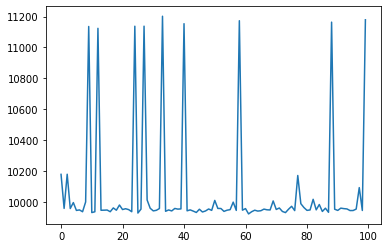

In [413]:
pyplot.plot(res["llTrajectory"])
res

In [89]:
binomH0 = Binomial(total_count=tensor([1.,1]), probs=pDs[0])

In [90]:
binomH0.log_prob(tensor(1.))

tensor([-4.6151, -4.6151])

In [49]:
costFn2 = likelihoodUnivariateFast(altCountsByGene, pDs)
# print(costFn2([1e-9, .999999]))
print(costFn2([1e-9, 1e-9]))
print(costFn2([0.08845797,0.11094360])) #gives ~12067 using jensen's method, and ~9887 using exponentiation of the log

# best result from R
#  0.08845797           0.11094360 , ll -10127.23, and with jensen's version, "example -12037.4347455843"
# pDgivenV, pi1


params are [1e-09, 1e-09]
pDgivenV 1e-09
pi0 0.999999999
binomH0 at the bad place of 6780 tensor([0.9327, 0.9235, 0.1218]) where the sums are tensor([ 7.,  8., 14.]) and probs are tensor(0.0099) and altCounts are tensor([0., 0., 1.])
component0 tensor([0.9143, 0.8963, 0.0565,  ..., 0.9235, 0.9327, 0.8963]) component1 tensor([1.0000e-09, 1.0000e-09, 7.1525e-16,  ..., 1.0000e-09, 1.0000e-09,
        1.0000e-09]) sum tensor([0.9143, 0.8963, 0.0565,  ..., 0.9235, 0.9327, 0.8963]) log tensor([-0.0896, -0.1095, -2.8731,  ..., -0.0796, -0.0697, -0.1095])
log sum tensor(-10964.6426)
tensor(10964.6426)
params are [0.08845797, 0.1109436]
pDgivenV 0.1109436
pi0 0.91154203
binomH0 at the bad place of 6780 tensor([0.9327, 0.9235, 0.1218]) where the sums are tensor([ 7.,  8., 14.]) and probs are tensor(0.0099) and altCounts are tensor([0., 0., 1.])
component0 tensor([0.8335, 0.8170, 0.0515,  ..., 0.8418, 0.8502, 0.8170]) component1 tensor([0.0307, 0.0243, 0.0327,  ..., 0.0345, 0.0388, 0.0243]) sum t

In [ ]:
costFn = likelihoodUnivariate(altCountsByGene, pDs)
print("costFn1:", costFn([.001, .01]),"costFn2:",costFn2([.001, .01]))

In [49]:
costFn([0.0001,0.11094360])

skipping 6780
skipping 7044
skipping 7241
skipping 7579
skipping 11089
skipping 11642
skipping 11813
skipping 12044
skipping 12389
skipping 15026
skipping 16708


tensor(12764.8105)

In [60]:
print(costFn2([0.0001,0.11094360]))

params are [0.0001, 0.1109436]
pDgivenV 0.1109436
pi0 0.9999
binomH0 at the bad place of 6780 tensor([-0.1393, -0.0000, -0.0896]) where the sums are tensor([14.,  0.,  9.])
components tensor([-4.9825, -7.6460, -2.4972,  ..., -0.0398, -3.0452, -0.1094]) tensor([-1.3343e-04, -1.7970e-04, -9.4227e-05,  ..., -4.7038e-05,
        -1.0597e-04, -1.2935e-04])
tensor(11075.9297)


In [31]:
d = Binomial(total_count=tensor([14., 0., 9.]), probs=tensor(.0099))
d.log_prob(tensor([0.,0.,0.]))

tensor([-0.1393, -0.0000, -0.0895])

In [551]:
costFn2([1e-9, .999999])

params are [1e-09, 0.999999]
pDgivenV 1e-09
pi0 1.0000000000287557e-06
components tensor([-6.9653e-08, -9.4742e-06, -4.8388e-06,  ..., -8.9553e-08,
        -1.1940e-07, -4.9752e-08]) tensor([-9.5367e-07, -4.3396e+01, -2.7374e+01,  ..., -9.5367e-07,
        -1.9073e-06, -4.7684e-07])
ll: -51670.8515625


-51670.8515625

In [30]:
binomH0 = Binomial(total_count=geneSums, probs=.001)
binomH1 = Binomial(total_count=geneSums, probs=.01)
caseAltCounts = altCountsByGene[:, 0, 1]
print(caseAltCounts)
component0 = binomH0.log_prob(caseAltCounts)
print("component0", component0, .5*component0)
component1 = binomH1.log_prob(caseAltCounts)

NameError: name 'geneSums' is not defined

In [476]:
pDgivenV(pDs[0], afsByGene2[0:2000, 0, 1].mean(), afMean)

tensor(0.0987)

In [473]:
condition1 = altCountsByGene2[:, 0, :]
condition1
pDs[0]

afsByGene2[0:2000,:,1].mean()

tensor(0.0008)

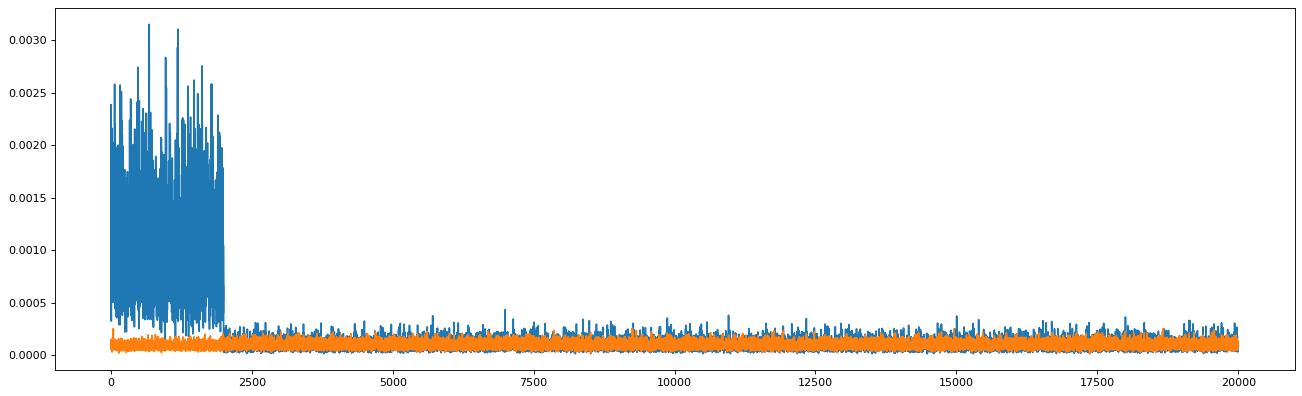

In [472]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGene2[:, 0, 1:2].flatten())
pyplot.plot(afsByGene2[:, 0, 0:1].flatten())

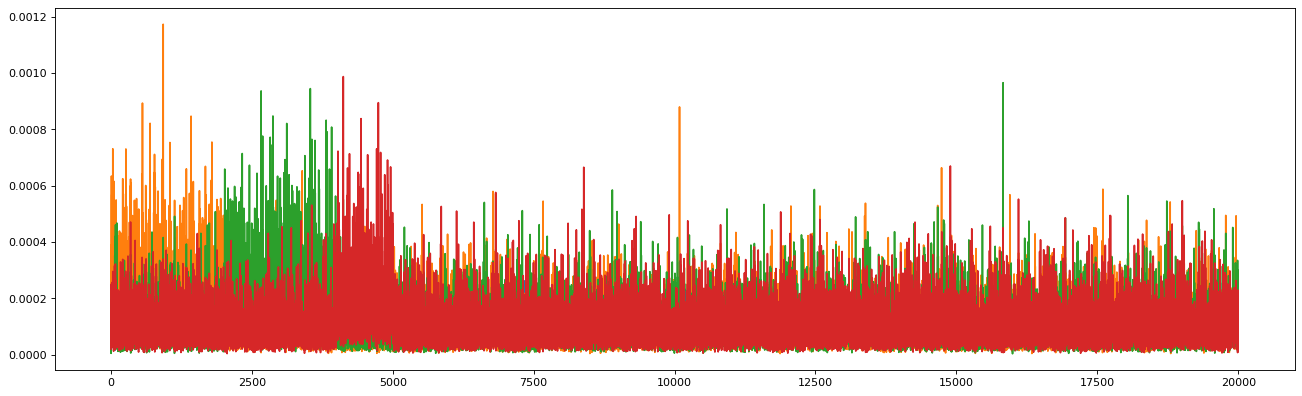

In [336]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGenePooledCtrls[:, 0, 0:1].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 0, 1:2].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 1, 1:2].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 2, 1:2].flatten())
# pyplot.plot(afsByGeneRR2[:, 0, 1:2].flatten())
# pyplot.plot(afsByGeneRR2[:, 0, 0:1].flatten())

In [455]:
flattenedData = []

for geneAfData in afsByGenePooledCtrls:
    flattenedData.append([geneAfData[0][0],*geneAfData[:, 1]])

In [554]:
DirichletMultinomial?

Init signature:
DirichletMultinomial(
    concentration,
    total_count=1,
    is_sparse=False,
    validate_args=None,
)
Docstring:     
Compound distribution comprising of a dirichlet-multinomial pair. The probability of
classes (``probs`` for the :class:`~pyro.distributions.Multinomial` distribution)
is unknown and randomly drawn from a :class:`~pyro.distributions.Dirichlet`
distribution prior to a certain number of Categorical trials given by
``total_count``.

:param float or torch.Tensor concentration: concentration parameter (alpha) for the
    Dirichlet distribution.
:param int or torch.Tensor total_count: number of Categorical trials.
:param bool is_sparse: Whether to assume value is mostly zero when computing
    :meth:`log_prob`, which can speed up computation when data is sparse.
File:           ~/miniconda3/lib/python3.7/site-packages/pyro/distributions/conjugate.py
Type:           ABCMeta
Subclasses:     


In [553]:
dist.Dirichlet(0.5 * torch.ones(4)).sample([10_000]).mean(0)

tensor([0.2491, 0.2539, 0.2495, 0.2475])

In [456]:
flattenedData = tensor(flattenedData)

<Figure size 432x288 with 0 Axes>

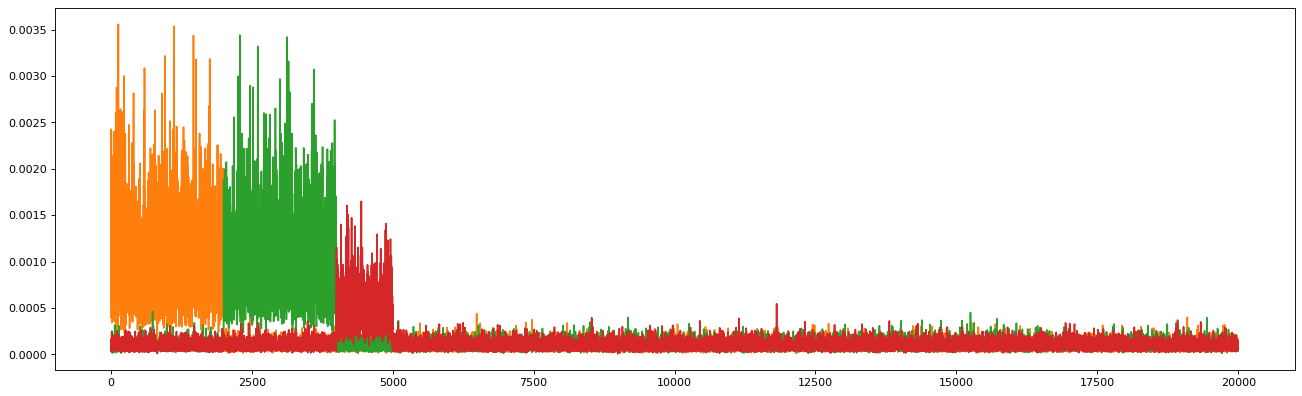

In [459]:
flattenedData
pyplot.clf()
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(flattenedData)

In [2]:
ctrlCounts = altCountsByGene[:, 0, 0]
altCountsCases = altCountsByGene[:, :, 1]

altCountsFlat = []
for geneIdx in range(nGenes):
    altCountsFlat.append([ctrlCounts[geneIdx], *altCountsByGene[geneIdx, :, 1].flatten()])
altCountsFlat = tensor(altCountsFlat)

NameError: name 'altCountsByGene' is not defined

In [1]:
altCountsFlat[0]

NameError: name 'altCountsFlat' is not defined

In [569]:
DirichletMultinomial?

Init signature:
DirichletMultinomial(
    concentration,
    total_count=1,
    is_sparse=False,
    validate_args=None,
)
Docstring:     
Compound distribution comprising of a dirichlet-multinomial pair. The probability of
classes (``probs`` for the :class:`~pyro.distributions.Multinomial` distribution)
is unknown and randomly drawn from a :class:`~pyro.distributions.Dirichlet`
distribution prior to a certain number of Categorical trials given by
``total_count``.

:param float or torch.Tensor concentration: concentration parameter (alpha) for the
    Dirichlet distribution.
:param int or torch.Tensor total_count: number of Categorical trials.
:param bool is_sparse: Whether to assume value is mostly zero when computing
    :meth:`log_prob`, which can speed up computation when data is sparse.
File:           ~/miniconda3/lib/python3.7/site-packages/pyro/distributions/conjugate.py
Type:           ABCMeta
Subclasses:     


In [586]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)

K = 4  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))

    with pyro.plate('components', K):
        concentrations = pyro.sample('concentrations', dist.Dirichlet(0.5 * torch.ones(K)))

    with pyro.plate('data', len(data)):
        # Local variables.
        component = pyro.sample('assignment', dist.Categorical(weights))
        print(f"concentrations: {concentrations[component]}")
        pyro.sample('obs', DirichletMultinomial(concentration=concentrations[component], total_count=data.sum(1)), obs=data)

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [587]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "concentrations":
        return torch.ones(K) / K
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'concentrations']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, altCountsFlat)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(2))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

concentrations: tensor([0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500])
concentrations: tensor([[[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]]], grad_fn=<IndexBackward>)
concentrations: tensor([0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500])
concentrations: tensor([[[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]]], grad_fn=<IndexBackward>)
concentrations: tensor([0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.2500])
concentrations: tensor([[[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500]]], grad_fn=<IndexBackward>)
seed = 0, initial_loss = 67835.1484375


In [572]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(altCountsFlat)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

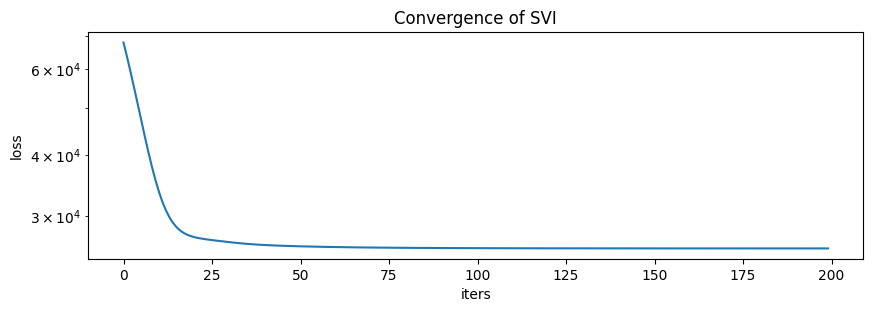

In [573]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

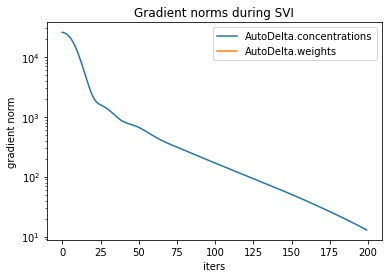

In [574]:
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [576]:
map_estimates = global_guide(altCountsFlat)
weights = map_estimates['weights']
locs = map_estimates['concentrations']
print('weights = {}'.format(weights.data.numpy()))
print('concentrations = {}'.format(locs.data.numpy()))

weights = [0.25 0.25 0.25 0.25]
concentrations = [[0.8973397  0.0494441  0.04917945 0.00403667]
 [0.8973397  0.0494441  0.04917945 0.00403667]
 [0.8973397  0.0494441  0.04917945 0.00403667]
 [0.8973397  0.0494441  0.04917945 0.00403667]]


In [579]:
Dirichlet(tensor([0.8973397  , 0.0494441,  0.04917945, 0.00403667])).sample([10_000,]).mean()

tensor(0.2500)